# Piezometry in a heterogeneous coastal aquifer

In [1]:

# Filter warnings (before imports)
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pkg_resources # Must be placed after DeprecationWarning as it is itself deprecated
warnings.filterwarnings('ignore', message='.*pkg_resources.*')
warnings.filterwarnings('ignore', message='.*declare_namespace.*')

# Libraries installed by default
import sys
import os

# Libraries need to be installed if not
import numpy as np
import pandas as pd


# Libraries added from 'conda install' procedure
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

# Libraries added from 'conda forge' procedure

import whitebox
wbt = whitebox.WhiteboxTools()
wbt.verbose = False



In [2]:

from os.path import dirname, abspath
root_dir = '/home/agauvain/Git/HydroModPy'
sys.path.append(root_dir)
print("Root path directory is: {0}".format(root_dir.upper()))



Root path directory is: /HOME/AGAUVAIN/GIT/HYDROMODPY


In [3]:

import src
import importlib
importlib.reload(src)

# Import HydroModPy modules
from src import watershed_root
from src.watershed import climatic, geographic, geology, hydraulic, hydrography, hydrometry, intermittency, oceanic, piezometry, subbasin
from src.modeling import downslope, modflow, modpath, timeseries
from src.display import visualization_watershed, visualization_results, export_vtuvtk
from src.tools import toolbox, folder_root

fontprop = toolbox.plot_params(8,15,18,20) # small, medium, interm, large



In [4]:

example_path = os.path.join(root_dir, "examples", "05_piezometry in a heterogeneous coastal aquifer/")
data_path = os.path.join(example_path, "data/")

# The folder out_path is created in the example_path root directory:
out_path = os.path.join(root_dir,'examples', 'results')
# Or define it manually
# out_path = 'C:/Simulations/HydroModPy/'

print('The results of the example will be saved here :', out_path)



The results of the example will be saved here : /home/agauvain/Git/HydroModPy/examples/results


In [5]:

dem_path = data_path + "MNT_gouville_25m.tif"

watershed_name = 'Example_05_Gouville'
from_lib = None # os.path.join(root_dir,'watershed_library.csv')
from_dem = None # [path, cell size]
from_shp = [data_path + 'model_area.shp', 10] # [path, buffer size]
from_xyv = None # [x, y, snap distance, buffer size]
bottom_path = None # path
modflow_path = os.path.join(root_dir,'bin/')
save_object = True



In [6]:

print('##### '+watershed_name.upper()+' #####')

load = True
BV = watershed_root.Watershed(dem_path=dem_path,
                              out_path=out_path,
                              load=load,
                              watershed_name=watershed_name,
                              from_lib=from_lib, # os.path.join(root_dir,'watershed_library.csv')
                              from_dem=from_dem, # [path, cell size]
                              from_shp=from_shp, # [path, buffer size]
                              from_xyv=from_xyv, # [x, y, snap distance, buffer size]
                              bottom_path=bottom_path, # path
                              save_object=save_object)

# Paths generated automatically but necessary for plots
stable_folder = out_path+'/'+watershed_name+'/'+'results_stable/'
simulations_folder = out_path+'/'+watershed_name+'/'+'results_simulations/'



##### EXAMPLE_05_GOUVILLE #####
      __  __          __           __  ____          ________     
     / / / /         / /          /  \/   /         / / __  /     
    / /_/ /_  ______/ /________  /       /___  ____/ / /_/ /_  __ 
   / __  / / / / __  / ___/ __ \/ /\,-/ / __ \/ __  / ____/ / / / 
  / / / / /_/ / /_/ / /  / /_/ / /   / / /_/ / /_/ / /   / /_/ /  
 /_/ /_/\__, /_____/_/   \____/_/   /_/\____/_____/_/____\__, /   
       /____/ Hydrological Modelling in Python /_____________/    
                                                                  
Python object was successfully loaded as requested; imported from output directory


Extract piezometry from web or specific data


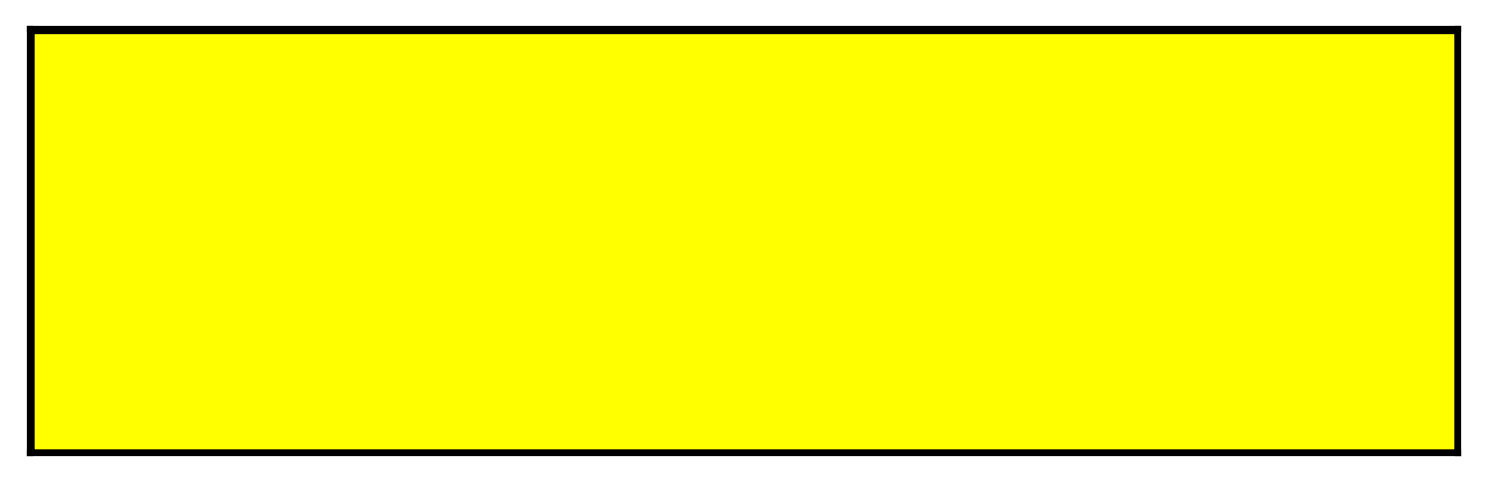

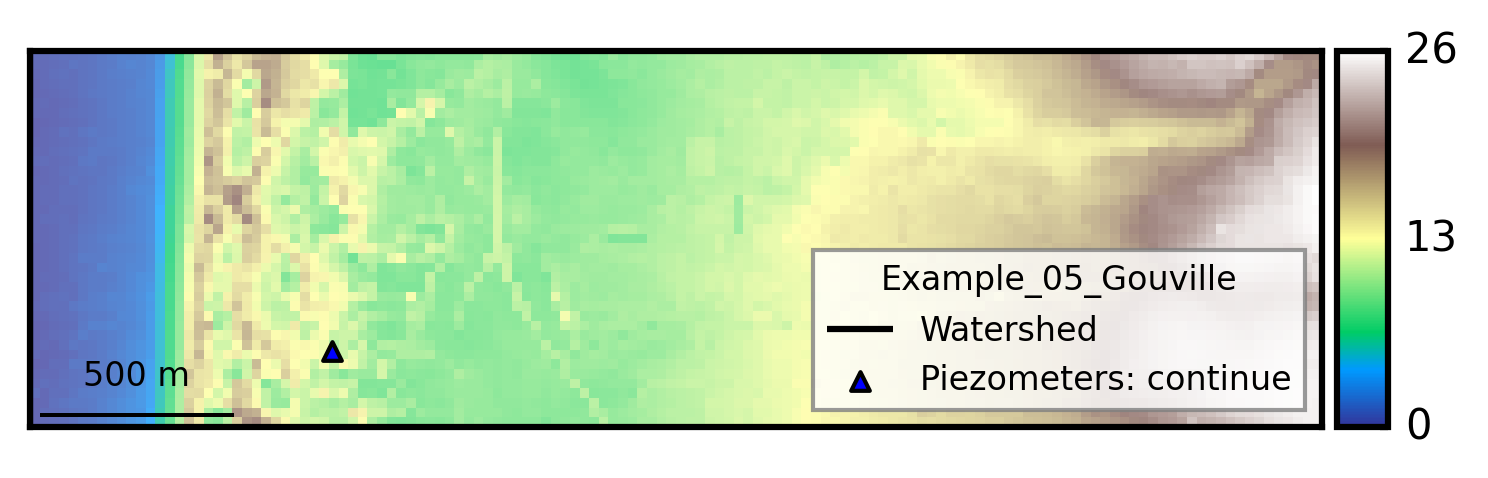

In [7]:

visualization_watershed.watershed_local(dem_path, BV)

# Clip specific data at the catchment scale
oceanic_path = data_path
BV.add_oceanic(oceanic_path) # import specific data of tide temporal dynamcis
BV.add_piezometry() # download data on the web

# General plot of the study site
visualization_watershed.watershed_dem(BV)



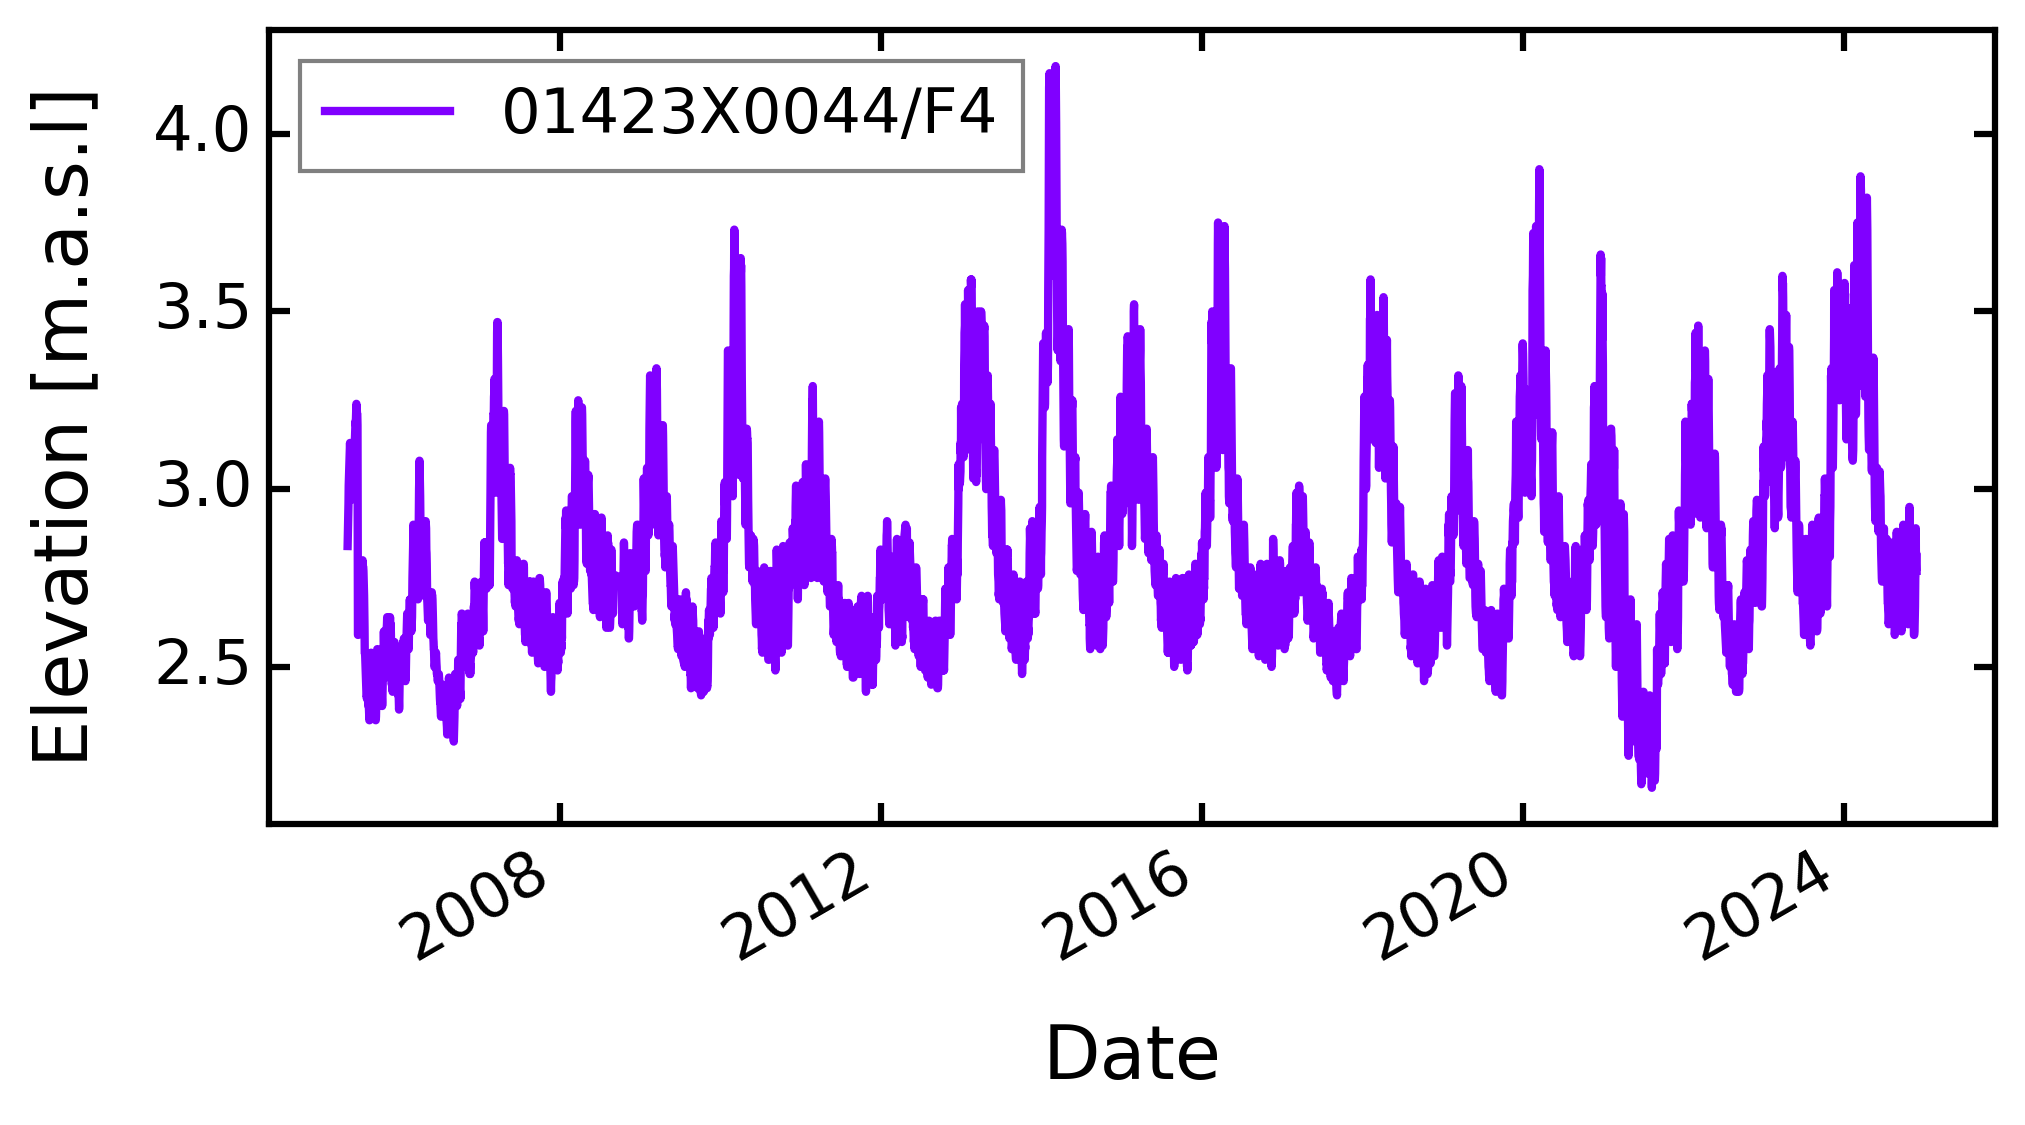

In [8]:

code = '01423X0044/F4' #BSS piezometer code

file = os.path.join(data_path, 'piezo.txt')
df = pd.read_csv(file, delimiter = '|',header=0, engine='python', encoding='latin1')
piezo_NGF_df = df[['Date de la mesure','Côte NGF']]
piezo_NGF_df.columns = ['Date', 'NGF']
piezo_2016 = piezo_NGF_df.copy()
piezo_NGF_df.index = piezo_NGF_df['Date']
piezo_NGF_df = piezo_NGF_df.drop(['Date'], axis=1)
piezo_NGF_df.columns = [code]

piezo_2016.index = pd.to_datetime(piezo_2016['Date'],format='%d/%m/%Y %H:%M:%S')
piezo_2016 = piezo_2016.drop(['Date'], axis=1)
piezo_2016 = piezo_2016[piezo_2016.index.year == 2016]

filename = 'piezometry_' + str.replace(code, '/', '') + '_363782_6897114_9.2_10' + '.csv' #check if needed
piezo_add_path = os.path.join(stable_folder, 'add_data',  filename)
if not os.path.exists(os.path.join(stable_folder, 'add_data')):
    os.mkdir(os.path.join(stable_folder, 'add_data'))
piezo_NGF_df.to_csv(piezo_add_path, sep = ';',)

# BV.piezometry.add_data()
BV.piezometry.display_data()



Init climatic module to set model parameter


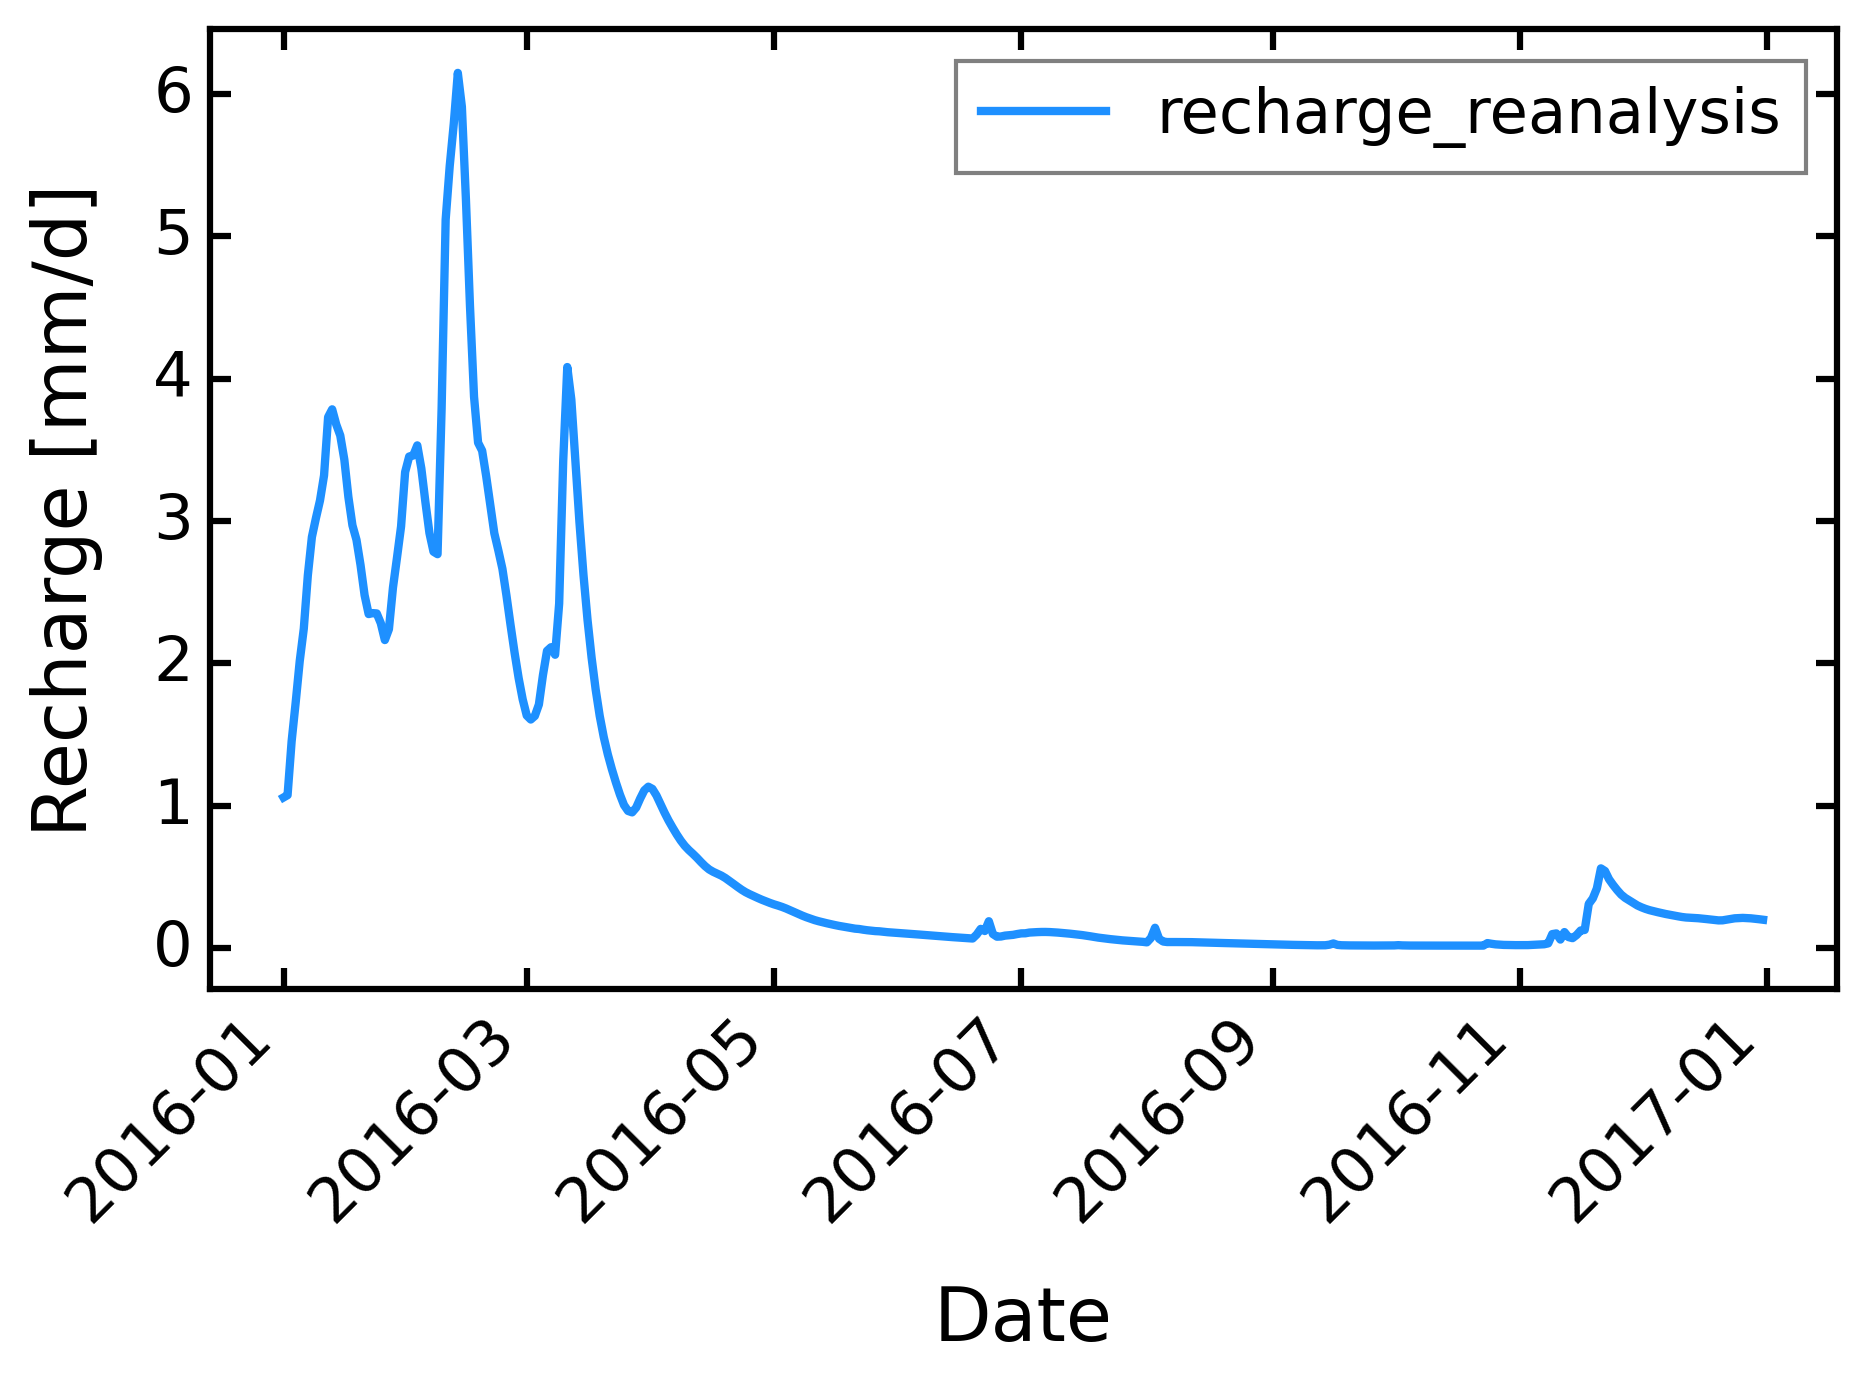

In [9]:

first_clim = 'mean'
freq_time = 'D'

BV.add_climatic()
BV.climatic.update_first_clim(first_clim)

BV.climatic.update_recharge_reanalysis(path_file = data_path + '_REC_D.csv',
                                       clim_mod='REA',
                                       clim_sce='historic',
                                       first_year=2016,
                                       last_year=2016,
                                       time_step=freq_time,
                                       sim_state='transient')
BV.climatic.update_first_clim(first_clim)
rec = BV.climatic.recharge

fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.plot(rec, label='recharge_reanalysis', c='dodgerblue', lw=2)
ax.set_xlabel('Date')
ax.set_ylabel('Recharge [mm/d]')
plt.xticks(rotation=45, ha="right")
ax.legend()

BV.climatic.update_recharge(rec/1000, sim_state='transient')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


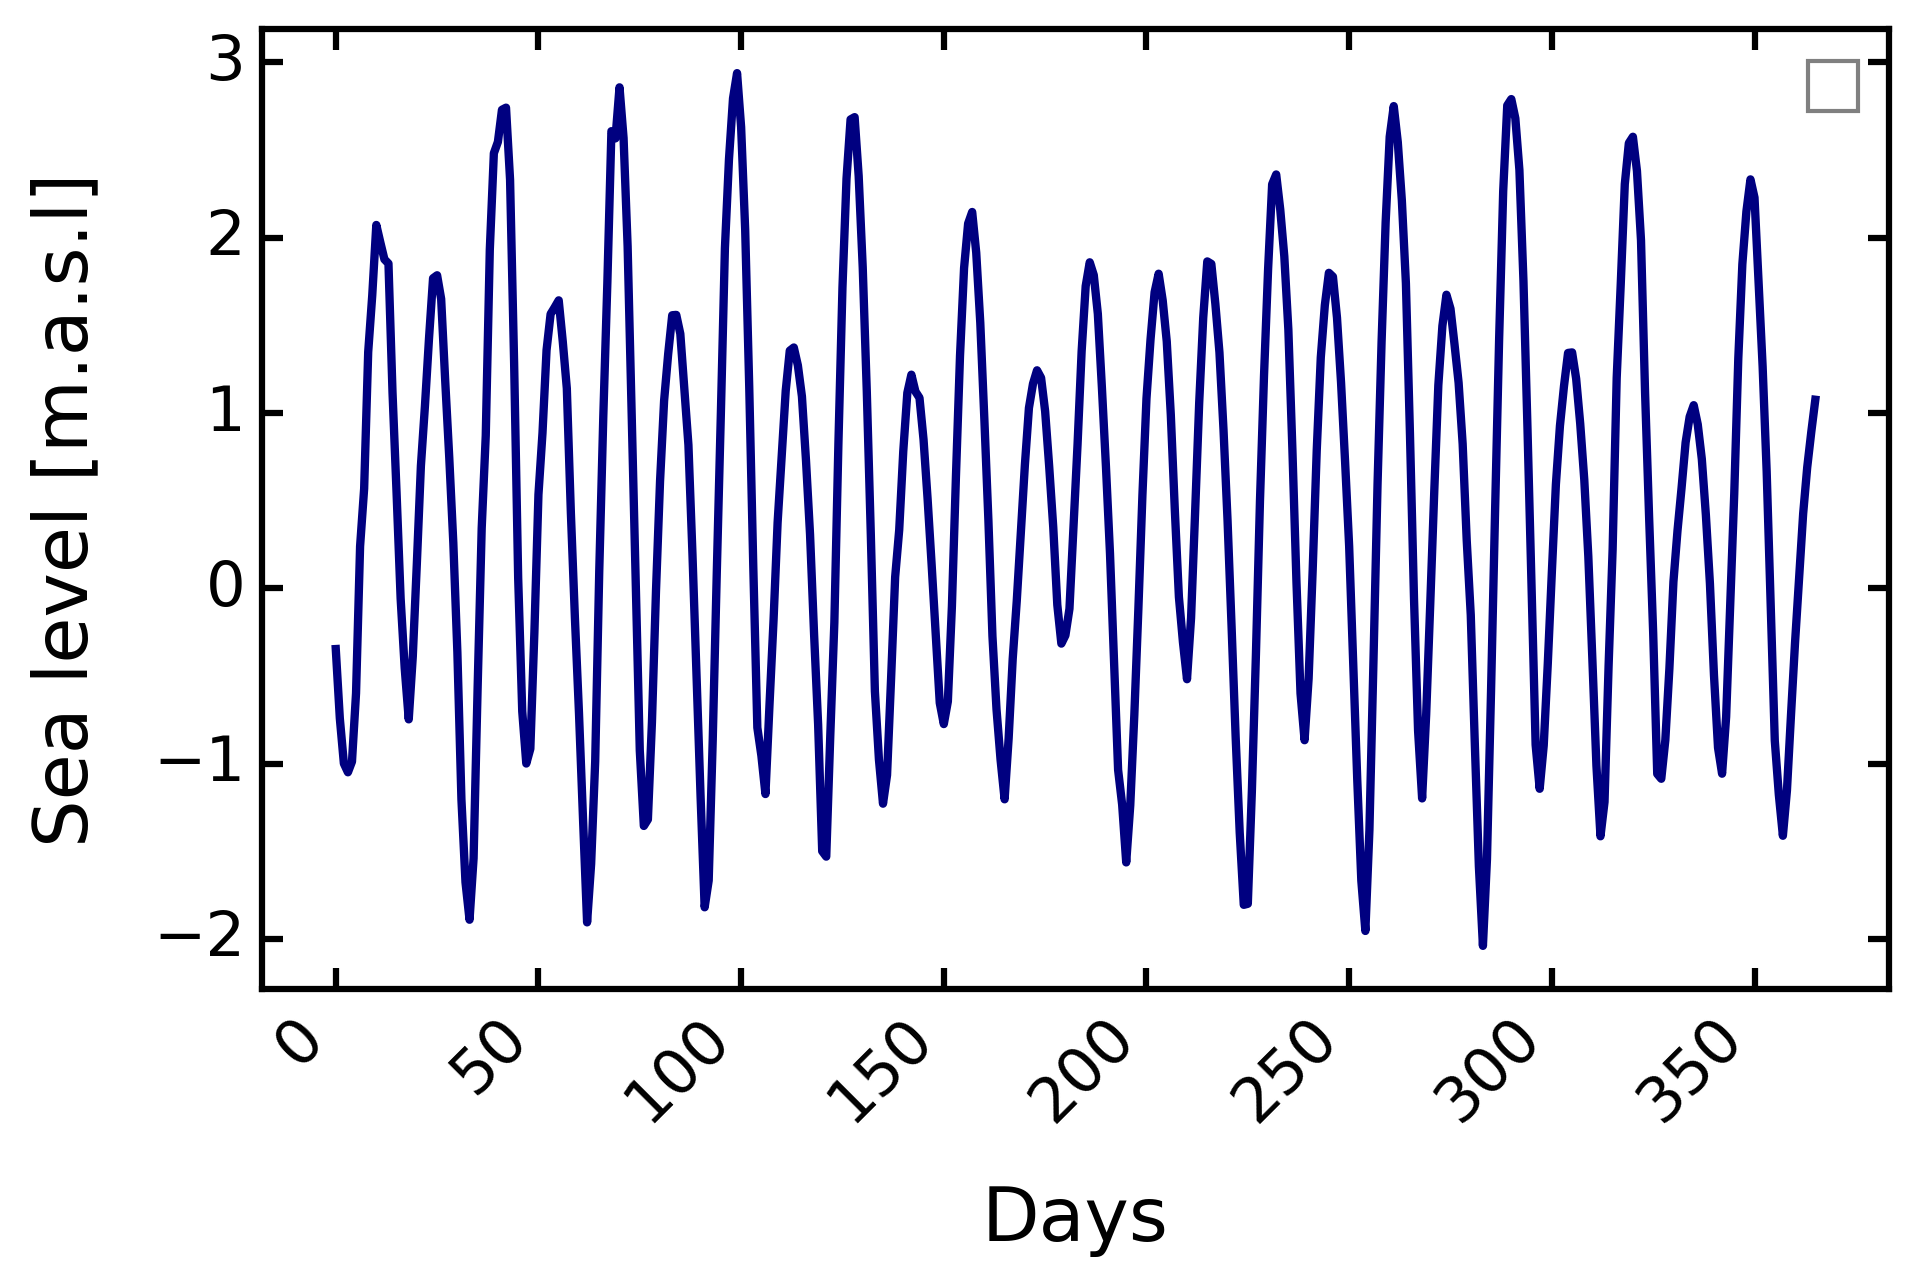

In [10]:

sea_lev = pd.read_csv(data_path + 'sea_level.csv', header=None)
sea_level = sea_lev[1].values.tolist()
BV.oceanic.update_MSL(sea_level)
sl = BV.oceanic.MSL

fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.plot(sl, c='navy', lw=2)
ax.set_xlabel('Days')
ax.set_ylabel('Sea level [m.a.s.l]')
plt.xticks(rotation=45, ha="right")
ax.legend()

# Since initial state of transient-state simulation is obtained
# using a permanent-state simulation based on t0 values,
# sea level at t0 is set to its mean value.
sea_level[0] = np.mean(sea_level)
BV.oceanic.update_MSL(sea_level)



In [11]:

# Frame settings
model_name = 'default'
box = False # or True
sink_fill = False # or True
sim_state = 'transient' # 'steady' or 'transient'
plot_cross = True
dis_perlen = False

# Hydraulic settings
nlay = 1
lay_decay = 1 # 1 for no decay
bottom = -20 # elevation in meters, None for constant aquifer thickness, or 2D matrix
thick = None # if bottom is None, aquifer thickness
cond_drain = None # or value of conductance

# Lateral heterogeneity of hydrodynamic parameters
hk_1 = 18.5 # m/day
hk_2 = 95 # m/day
sy_1 = 8 / 100 # -
sy_2 = 45 / 100 # -

# Boundary settings
bc_left = None # or value
bc_right = None # or value



In [12]:

# Import modules
BV.add_settings()
BV.add_hydraulic()

# Frame settings
BV.settings.update_model_name(model_name)
BV.settings.update_box_model(box)
BV.settings.update_sink_fill(sink_fill)
BV.settings.update_simulation_state(sim_state)
BV.settings.update_check_model(plot_cross=plot_cross)

# Hydraulic settings
BV.hydraulic.update_nlay(nlay) # 1
BV.hydraulic.update_lay_decay(lay_decay) # 1
BV.hydraulic.update_bottom(bottom) # None
BV.hydraulic.update_thick(thick) # 30 / intervient pas si bottom != None
BV.hydraulic.update_cond_drain(cond_drain)
BV.settings.update_dis_perlen(dis_perlen=dis_perlen)

# Lateral heterogeneity
shape_calib_zones_path = os.path.join(data_path, 'param_zones.shp')
BV.hydraulic.update_calib_zones_from_shp(shape_calib_zones_path)
calib_zones = BV.hydraulic.calib_zones
BV.hydraulic.update_hk_from_calib_zones(1, hk_1)
BV.hydraulic.update_hk_from_calib_zones(2, hk_2)
BV.hydraulic.update_sy_from_calib_zones(1, sy_1)
BV.hydraulic.update_sy_from_calib_zones(2, sy_2)

# Boundary settings
BV.settings.update_bc_sides(bc_left, bc_right)



Init settings module to set model parameter
Init hydraulic module to set model parameter


Check model grid: all cells satisfy the water flow connectivity condition
FloPy is using the following executable to run the model: ../../../../../bin/linux/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: default.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/01/09 13:17:01

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater-Flow Eqn.
 S

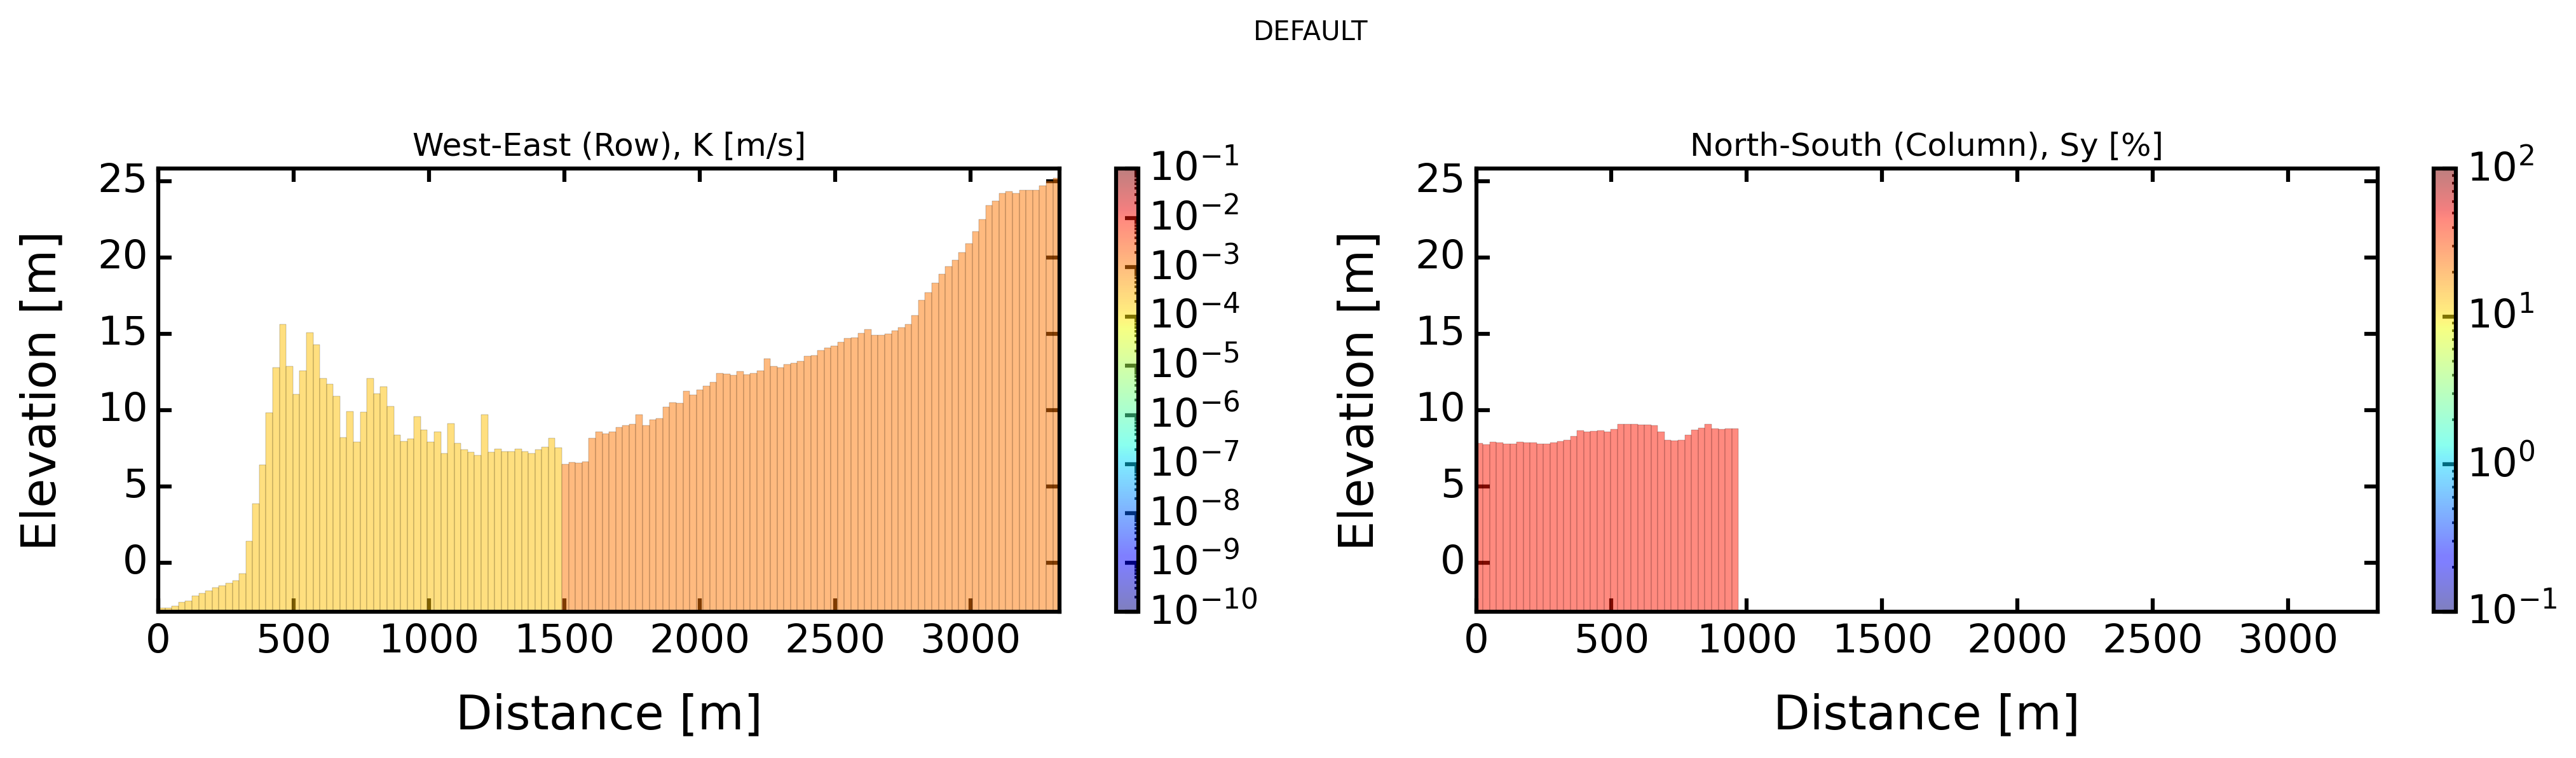

In [13]:

# BV.climatic.update_first_clim('first')

model_modflow = BV.preprocessing_modflow(for_calib=False)
success_modflow = BV.processing_modflow(model_modflow, write_model=True, run_model=True)
if success_modflow == True:
    BV.postprocessing_modflow(model_modflow,
                              watertable_elevation = True,
                              watertable_depth= True, 
                              seepage_areas = True,
                              outflow_drain = True,
                              groundwater_flux = True,
                              groundwater_storage = True,
                              accumulation_flux = False,
                              persistency_index=False,
                              intermittency_monthly=False,
                              intermittency_daily=False,
                              export_all_tif = False)
    timeseries_results = BV.postprocessing_timeseries(model_modflow=model_modflow,
                                                      model_modpath=None,
                                                      datetime_format=True, 
                                                      subbasin_results=False)
    netcdf_results = BV.postprocessing_netcdf(model_modflow,
                                              datetime_format=True)



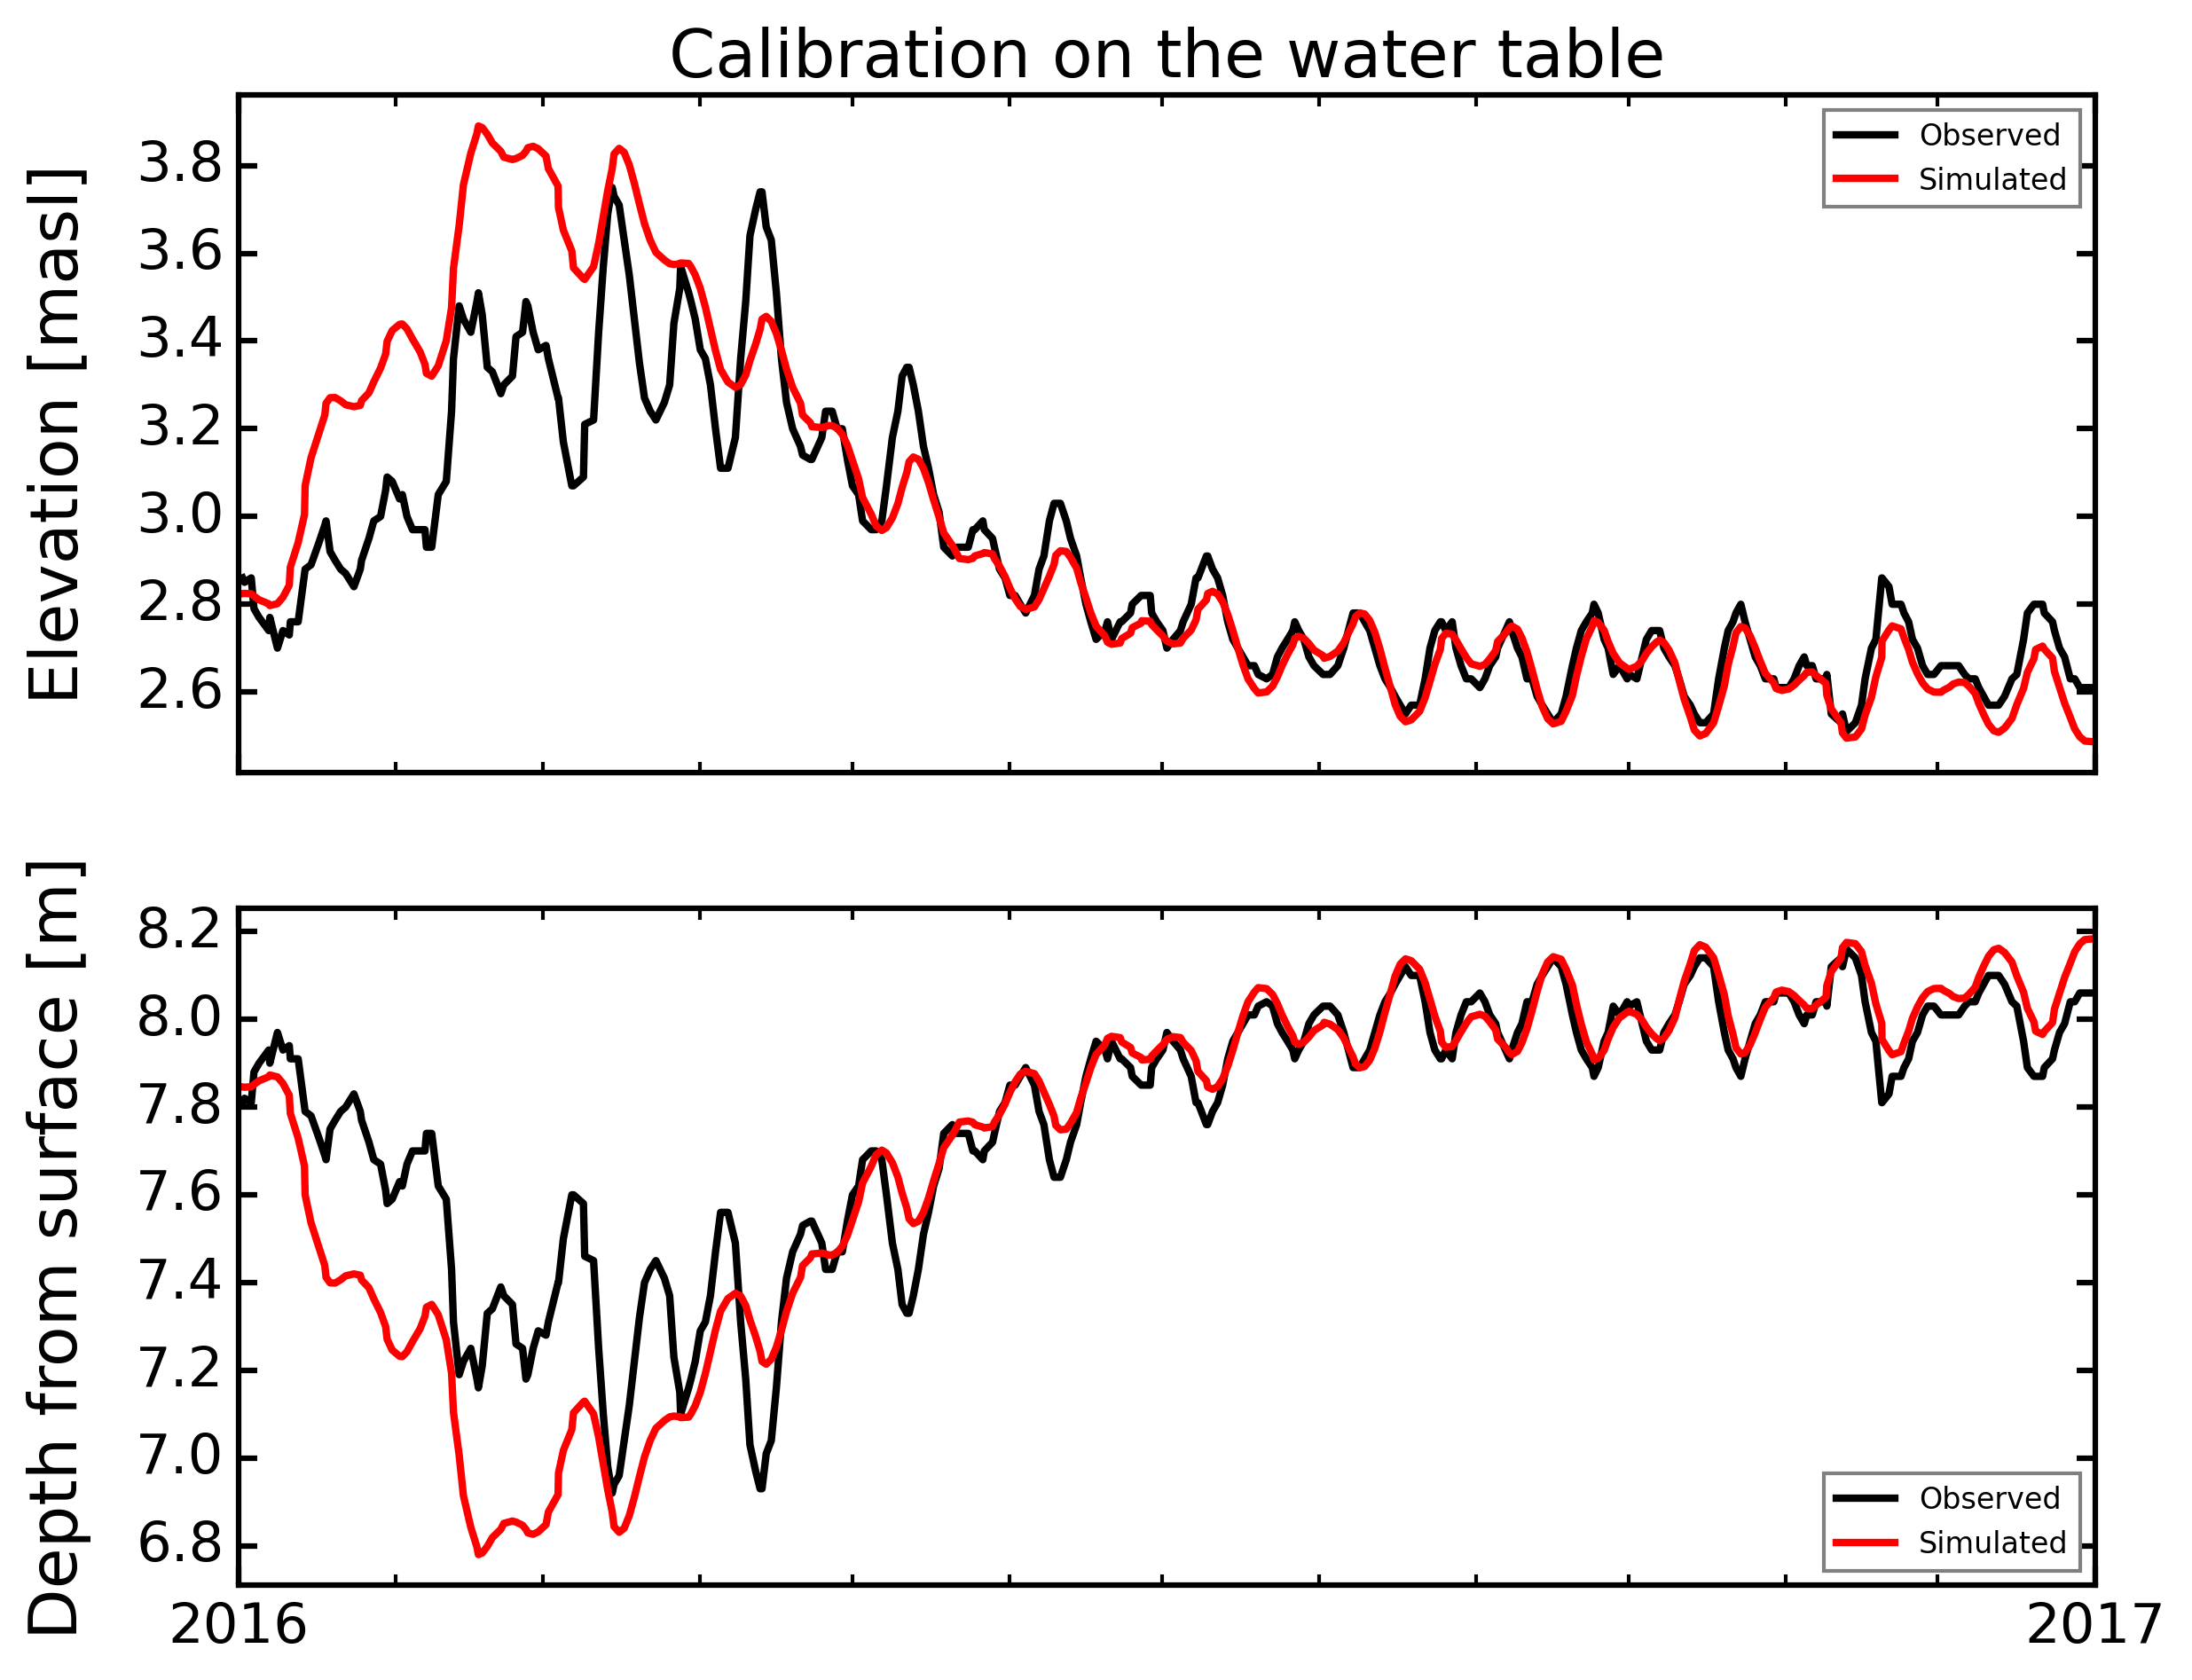

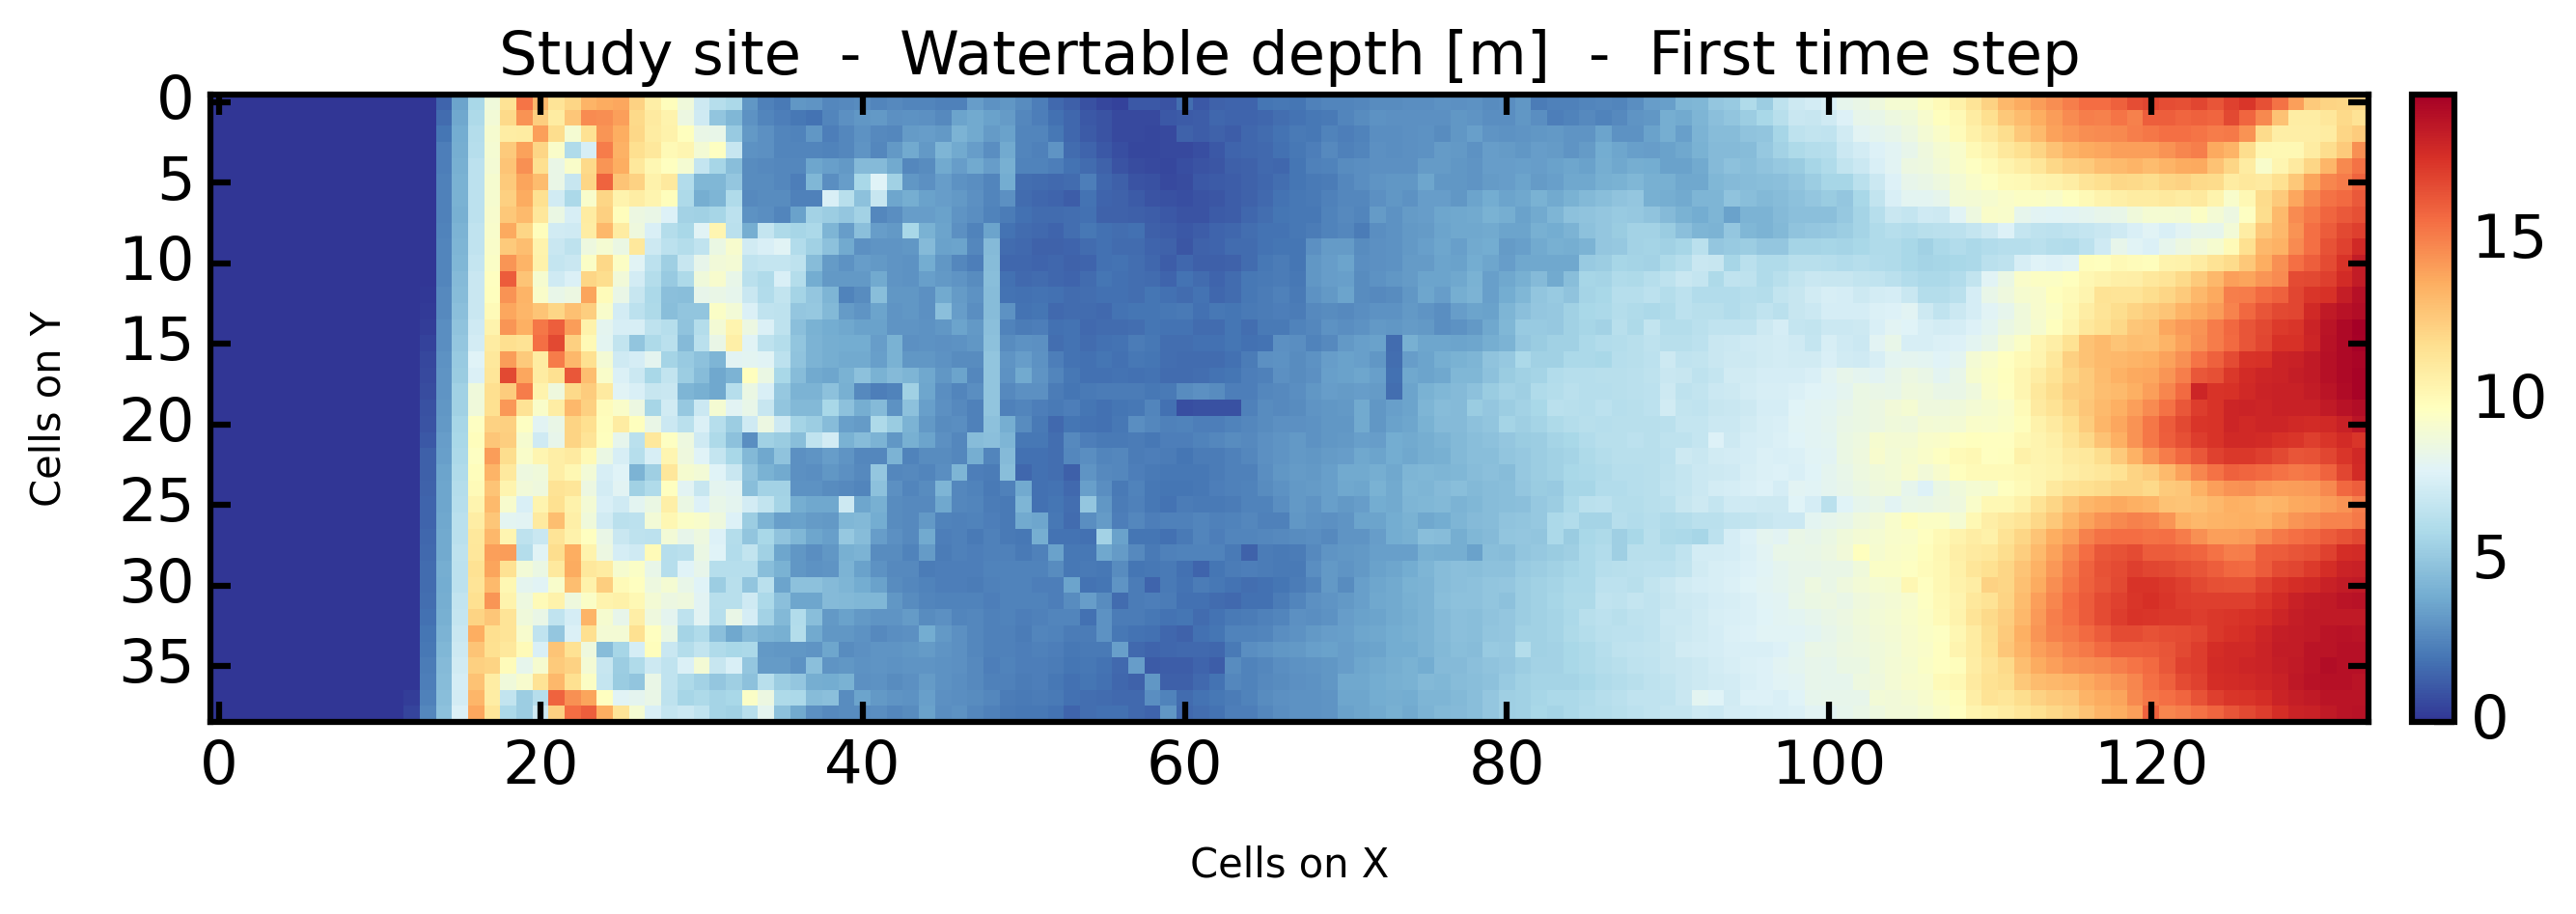

In [14]:

dem_data = BV.geographic.dem_clip

watertable_elevation = np.load(os.path.join(simulations_folder, 'default',
                                            '_postprocess', 'watertable_elevation.npy'),
                               allow_pickle=True).item()

sim_piezo_elev = []
for t in range(len(watertable_elevation)):
    sim_piezo_elev.append(watertable_elevation[t][BV.piezometry.x_iloc,BV.piezometry.y_iloc][0])
df_simobs_piezo_elev = piezo_2016.copy()
df_simobs_piezo_elev.insert(1, "Sim", sim_piezo_elev)

watertable_depth = np.load(os.path.join(simulations_folder, 'default',
                                            '_postprocess', 'watertable_depth.npy'),
                               allow_pickle=True).item()
sim_piezo_depth = []
for t in range(len(watertable_depth)):
    sim_piezo_depth.append(watertable_depth[t][BV.piezometry.x_iloc,BV.piezometry.y_iloc][0])
df_simobs_piezo_depth = piezo_2016.copy()
df_simobs_piezo_depth.insert(1, "Sim", sim_piezo_depth)

fig, axs = plt.subplots(2,1, figsize=(9,7), sharex=True)
axs = axs.ravel()

ax = axs[0]
ax.plot(df_simobs_piezo_elev.NGF, label='Observed', color='k', lw=2)
ax.plot(df_simobs_piezo_elev.Sim, label='Simulated', color='red', lw=2)
years_maj = mdates.YearLocator()   # every year
months_maj = mdates.MonthLocator()  # every x month
ax.xaxis.set_major_locator(years_maj)
ax.xaxis.set_minor_locator(months_maj)
ax.legend(loc='upper right', fontsize=8)
ax.set_ylabel('Elevation [masl]')
ax.set_xlim(pd.to_datetime('2016-01'), pd.to_datetime('2017-01'))
ax.set_title('Calibration on the water table')

ax = axs[1]
# ax.axhline(dem_data[30,30], label='Topography', color='gold', lw=2)
ax.plot(dem_data[BV.piezometry.x_iloc,BV.piezometry.y_iloc]-df_simobs_piezo_depth.NGF, label='Observed', color='k', lw=2)
ax.plot(df_simobs_piezo_depth.Sim, label='Simulated', color='red', lw=2)
years_maj = mdates.YearLocator()   # every year
months_maj = mdates.MonthLocator()  # every x month
ax.xaxis.set_major_locator(years_maj)
ax.xaxis.set_minor_locator(months_maj)
ax.legend(loc='lower right', fontsize=8)
ax.set_ylabel('Depth from surface [m]')
ax.set_xlim(pd.to_datetime('2016-01'), pd.to_datetime('2017-01'))

fig, ax = plt.subplots(1,1, figsize=(10,3))
watertable_depth[0][watertable_depth[0]<0] = 0
im = ax.imshow(watertable_depth[0], cmap='RdYlBu_r')
ax.set_xlabel('Cells on X', fontsize=10)
ax.set_ylabel('Cells on Y', fontsize=10)
ax.set_title('Study site  -  Watertable depth [m]  -  First time step', fontsize=15)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="2%", pad="2%")
cb = fig.colorbar(im, cax=cax)
cb.set_ticks([0,5,10,15])



In [15]:

if sim_state == 'steady':
    if success_modflow == True:
        model_modpath = BV.preprocessing_modpath(model_modflow)
        success_modpath = BV.processing_modpath(model_modpath, write_model=True, run_model=True)
    if success_modpath == True:
        BV.postprocessing_modpath(model_modpath,
                                  ending_point=True,
                                  starting_point=True,
                                  pathlines_shp=True,
                                  particles_shp=True,
                                  random_id=100)



In [16]:

if from_dem == None:
    subbasin_results = True
else:
    subbasin_results = False

if sim_state == 'steady':
    model_modpath = model_modpath
else:
    model_modpath = None

timeseries_results = BV.postprocessing_timeseries(model_modflow=model_modflow,
                                                  model_modpath=model_modpath,
                                                  datetime_format=True, 
                                                  subbasin_results=subbasin_results) # or None



   Export results as timeseries
